In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any
import sys
import copy
import matplotlib.pyplot as plt
import itertools
from fractions import Fraction
from decimal import Decimal

from src.dataclass import (
    Input, Lattice, Parameter, Train, Save,
    Processed_Input, Topology, Conjugate, Result
)

from src.manage_data import Data, get_result, get_correlation_length, get_size
from src.manage_data import save_result, save_log, load_result

In [2]:
df = load_result()
df.columns.values

array(['key', 'state', 'size', 'dimension', 'ghost', 'initial', 'T', 'H',
       'Tc', 'Hc', 'Jm', 'Jv', 'mode', 'variable', 'multiply', 'base',
       'exponent', 'iteration', 'sweep', 'measurement', 'interval',
       'ensemble', 'max_workers', 'threshold', 'recent', 'environment',
       'save', 'order_parameter', 'susceptibility', 'binder_cumulant',
       'spin_glass_order', 'spin_glass_suscept', 'spin_glass_binder',
       'energy', 'specific_heat', 'irreducible_distance',
       'correlation_function', 'autocorrelation', 'time'], dtype=object)

In [3]:
# df

In [4]:
state, dimension = (3, 2)

yt, yh, Tc = (Fraction(6,5), Fraction(28,15), 1.494)
print(yt, yh, Tc)

alpha, beta, gamma, delta, nu, eta = (
    2-dimension/yt,
    (dimension-yh)/yt,
    (2*yh-dimension)/yt,
    yh/(dimension-yh),
    1/yt,
    dimension-2*yh+2,
)

print(alpha, beta, gamma, delta, nu, eta)

size_list, Jv_list = (
    [8, 16, 32, 64, 128],
    [0.0, 1.0, 2.0, 3.0],
)

result = np.empty((np.size(size_list), np.size(Jv_list)), dtype=object)

for i, size in enumerate(size_list):
    for j, Jv in enumerate(Jv_list):
        result[i, j] = get_result(df, state, dimension, size, Jv)

print(result[size_list.index(64),Jv_list.index(1.0)].order_parameter)

6/5 28/15 1.494
1/3 1/9 13/9 14 5/6 4/15
[8.03842913e-01 7.07302926e-01 6.84319507e-01 4.74847106e-01
 2.14341848e-01 2.22097392e-02 1.15617231e-02 9.65066314e-03
 6.17698231e-03 3.86732453e-03 2.47334818e-03 2.03786328e-03
 1.90773488e-03 6.68113833e-04 1.36053022e-03 1.49490782e-03
 1.42836738e-03 1.28501370e-03 1.09908923e-03 9.28514419e-04
 9.59695208e-04 7.56973772e-04 7.63107841e-04 6.84604507e-04
 7.54421024e-04 3.36941193e-04 9.04939880e-04 4.12128917e-04
 8.32021993e-04 4.93158739e-04 4.08827778e-04 5.05046155e-04
 7.30170759e-04 6.33292591e-04 7.67886922e-04 2.56730636e-04
 8.22569957e-04 3.12488977e-04 6.05565387e-04 3.32798743e-04
 8.09002559e-04 5.97383361e-04 2.95323123e-04 5.99192106e-04
 1.67412225e-04 3.62630766e-04 3.45204942e-04 1.68459614e-04
 1.48441359e-04 2.61505680e-04 1.66676495e-04 7.79746333e-05
 1.25559483e-04 7.63963035e-05 9.73031274e-06 2.06301265e-05
 5.58087049e-06 3.47483001e-06 1.81207433e-05 1.42552526e-05]


In [5]:
# data

In [6]:
# !rm -rf ./result/000000.pkl

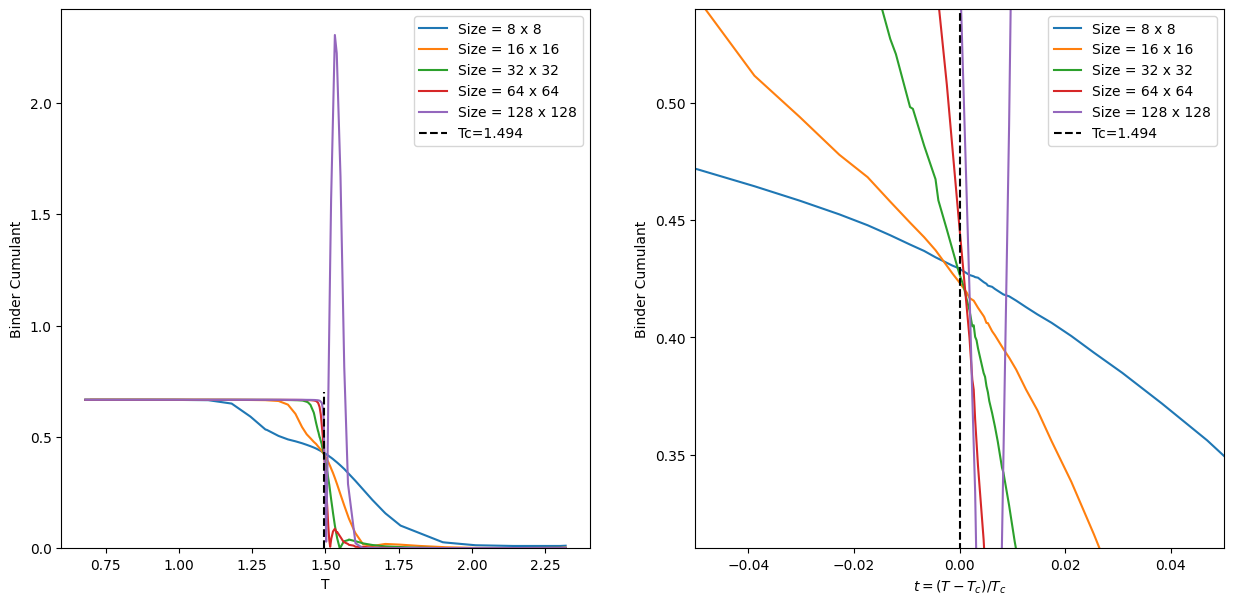

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Tc = 1.492

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.binder_cumulant, label=get_size(data))
    ax[1].plot((data.temperature-Tc)/Tc, data.binder_cumulant, label=get_size(data))
    
ax[0].vlines(Tc, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")
ax[1].vlines(0, 0, 0.7, linestyle="--", color="k", label=f"Tc={Tc}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Binder Cumulant")
ax[1].legend(loc="best")
ax[1].set_xlabel(r"$t=(T-T_c)/T_c$")
ax[1].set_xlim([-0.05, 0.05])
ax[1].set_ylim([0.31, 0.54])
ax[1].set_ylabel("Binder Cumulant")

plt.legend()
plt.show()

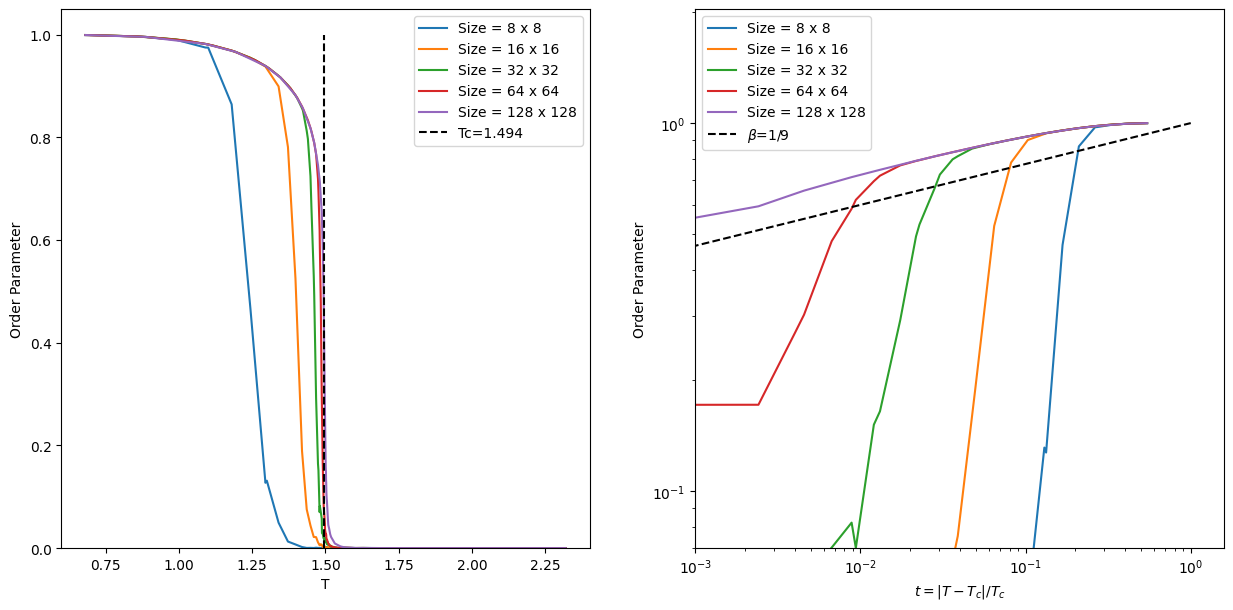

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Tc = 1.492
# beta = 1/9

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.order_parameter, label=get_size(data))
    ax[1].plot((Tc-data.temperature)/Tc, data.order_parameter, label=get_size(data))

ax[0].vlines(Tc, 0, 1, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(beta)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\beta$={beta}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Order Parameter")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t=|T-T_c|/T_c$")
ax[1].set_ylabel("Order Parameter")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([7.e-2, None])

plt.legend()
plt.show()

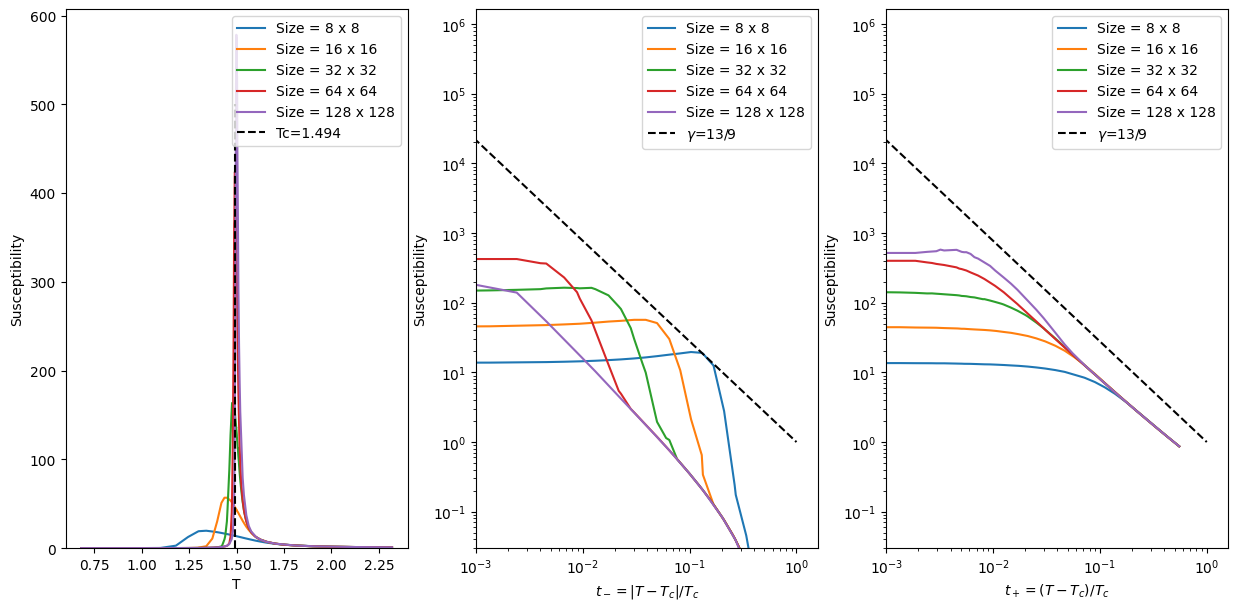

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# gamma = 13/9

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.susceptibility, label=get_size(data))
    ax[1].plot((Tc-data.temperature)/Tc, data.susceptibility, label=get_size(data))
    ax[2].plot((data.temperature-Tc)/Tc, data.susceptibility, label=get_size(data))

ax[0].vlines(Tc, 0, 500, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-gamma)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")
ax[2].plot(x, g(x), "--", color="k", label = fr"$\gamma$={gamma}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Susceptibility")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Susceptibility")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])

ax[2].legend(loc="best")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Susceptibility")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])

plt.legend()
plt.show()

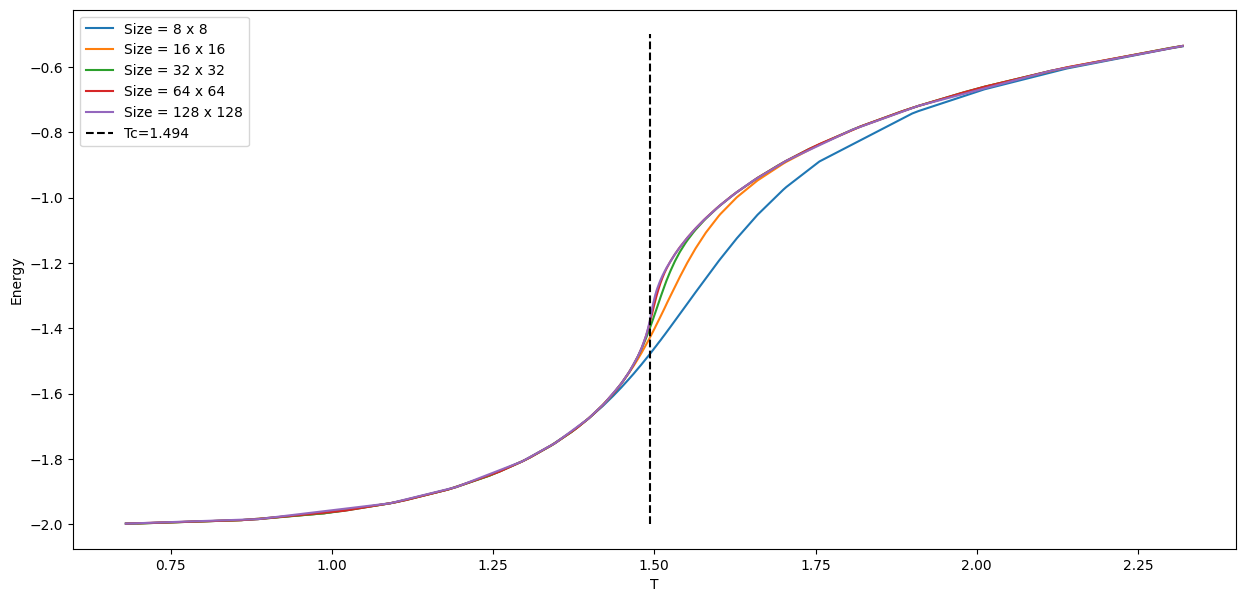

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

# Tc = 1.492

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax.plot(data.temperature, data.energy, label=get_size(data))

ax.vlines(Tc, -2, -0.5, linestyle="--", color="k", label=f"Tc={Tc}")

# ax.set_ylim([-2, None])
ax.legend(loc="best")
ax.set_xlabel("T")
ax.set_ylabel("Energy")

plt.legend()
plt.show()

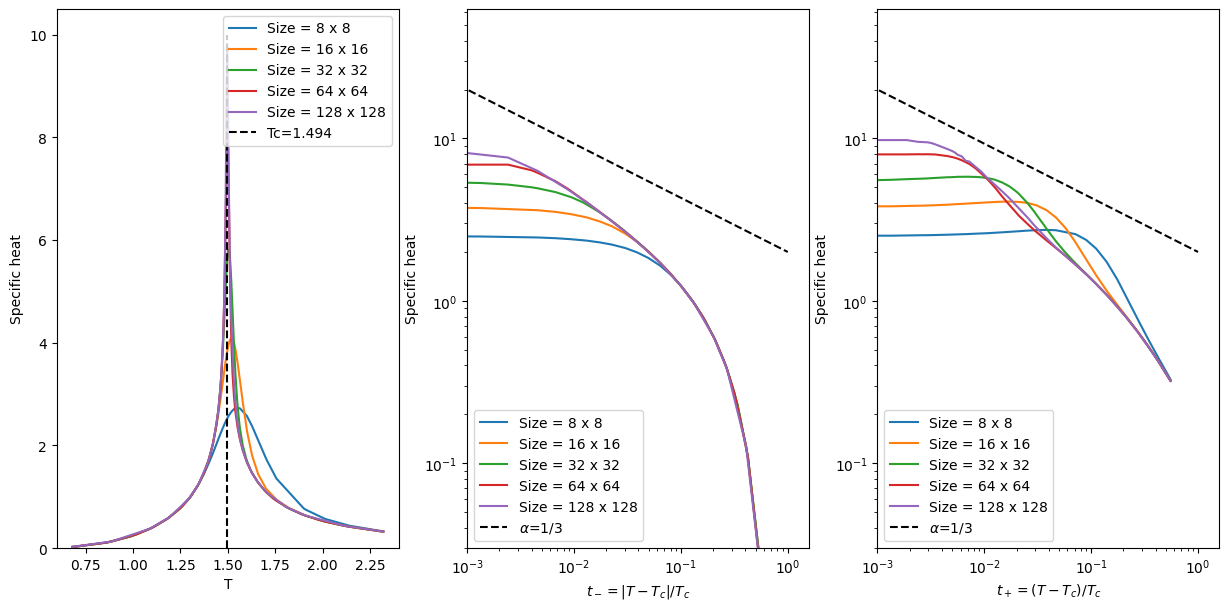

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# alpha = 1/3

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.specific_heat, label=get_size(data))
    ax[1].plot((Tc-data.temperature)/Tc, data.specific_heat, label=get_size(data))
    ax[2].plot((data.temperature-Tc)/Tc, data.specific_heat, label=get_size(data))

ax[0].vlines(Tc, 0, 10, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return 2 * x**(-alpha)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color = "black", label = fr"$\alpha$={alpha}")
ax[2].plot(x, g(x), "--", color = "black", label = fr"$\alpha$={alpha}")

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel("T")
ax[0].set_ylabel("Specific heat")

ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Specific heat")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])
ax[1].legend(loc="lower left")

ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Specific heat")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])
ax[2].legend(loc="lower left")

plt.show()

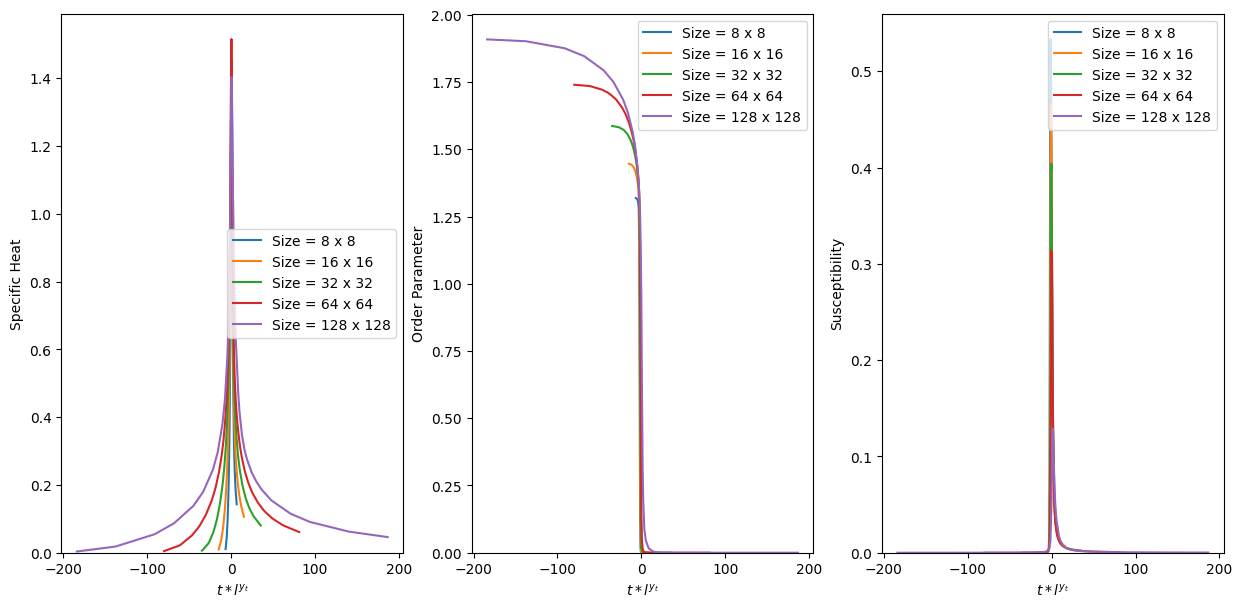

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# alpha = 1/3

Jv = 0.0

for data in result[:, Jv_list.index(Jv)]:
    ax[0].plot((data.temperature-Tc)/Tc*data.size**yt, data.specific_heat*data.size**(data.dimension-2*yt), label=get_size(data))
    ax[1].plot((data.temperature-Tc)/Tc*data.size**yt, data.order_parameter*data.size**(data.dimension-yh), label=get_size(data))
    ax[2].plot((data.temperature-Tc)/Tc*data.size**yt, data.susceptibility*data.size**(data.dimension-2*yh), label=get_size(data))

ax[0].set_ylim([0, None])
ax[0].legend(loc="best")
ax[0].set_xlabel(r"$t*l^{y_t}$")
ax[0].set_ylabel("Specific Heat")

ax[1].set_ylim([0, None])
ax[1].legend(loc="best")
ax[1].set_xlabel(r"$t*l^{y_t}$")
ax[1].set_ylabel("Order Parameter")

ax[2].set_ylim([0, None])
ax[2].legend(loc="best")
ax[2].set_xlabel(r"$t*l^{y_t}$")
ax[2].set_ylabel("Susceptibility")

plt.show()

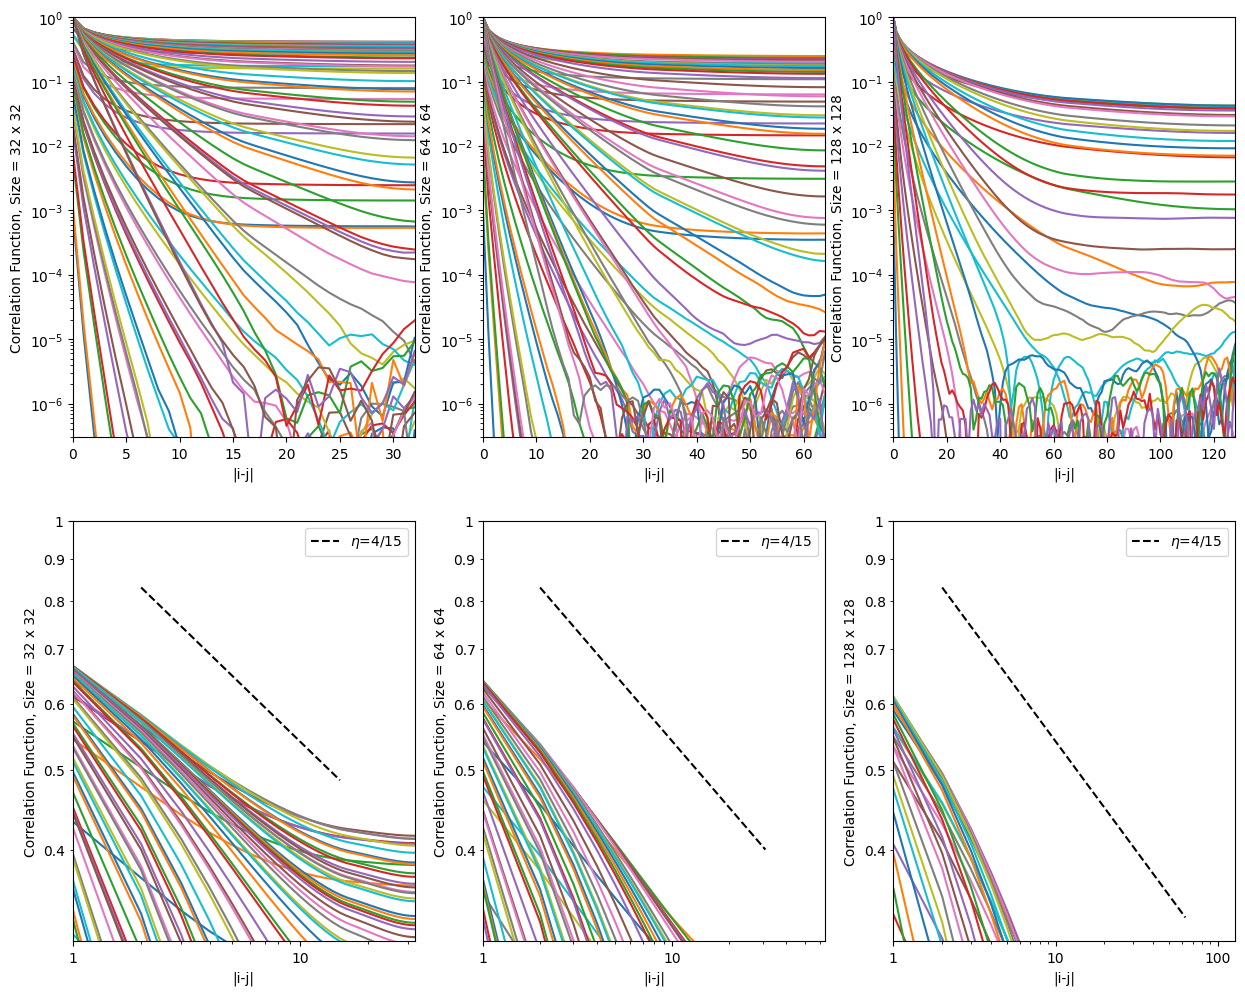

In [17]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: "{:.8g}".format(y))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

Jv = 0.0

for i, data in enumerate(result[size_list.index(32):size_list.index(128)+1, Jv_list.index(Jv)]):
    for j, irr_dist in enumerate(data.irreducible_distance):
        ax[0,i].plot(irr_dist, data.correlation_function[j])
        ax[1,i].plot(irr_dist, data.correlation_function[j])
    
    def g(x):
        return 1/x**(dimension-2+eta)
    x = np.arange(2,data.size/2)
    ax[1,i].plot(x,g(x),"--",color="k", label=fr"$\eta$={eta}")

    ax[0,i].set_yscale("log")
    ax[0,i].set_xlim(0, data.size*data.dimension/2)
    ax[0,i].set_ylim(3.e-7, 1.)
    ax[0,i].set_xlabel("|i-j|")
    ax[0,i].set_ylabel(f"Correlation Function, {get_size(data)}")
    
    ax[1,i].loglog()
    ax[1,i].set_xlim(1, data.size*data.dimension/2)
    ax[1,i].set_ylim(0.31, 1.)
    ax[1,i].legend(loc="best")
    ax[1,i].set_xlabel("|i-j|")
    ax[1,i].set_ylabel(f"Correlation Function, {get_size(data)}")
    
    ax[1,i].xaxis.set_major_formatter(formatter)
    # ax[1,i].xaxis.set_minor_formatter(formatter)
    ax[1,i].yaxis.set_major_formatter(formatter)
    ax[1,i].yaxis.set_minor_formatter(formatter)

# plt.legend()
plt.show()

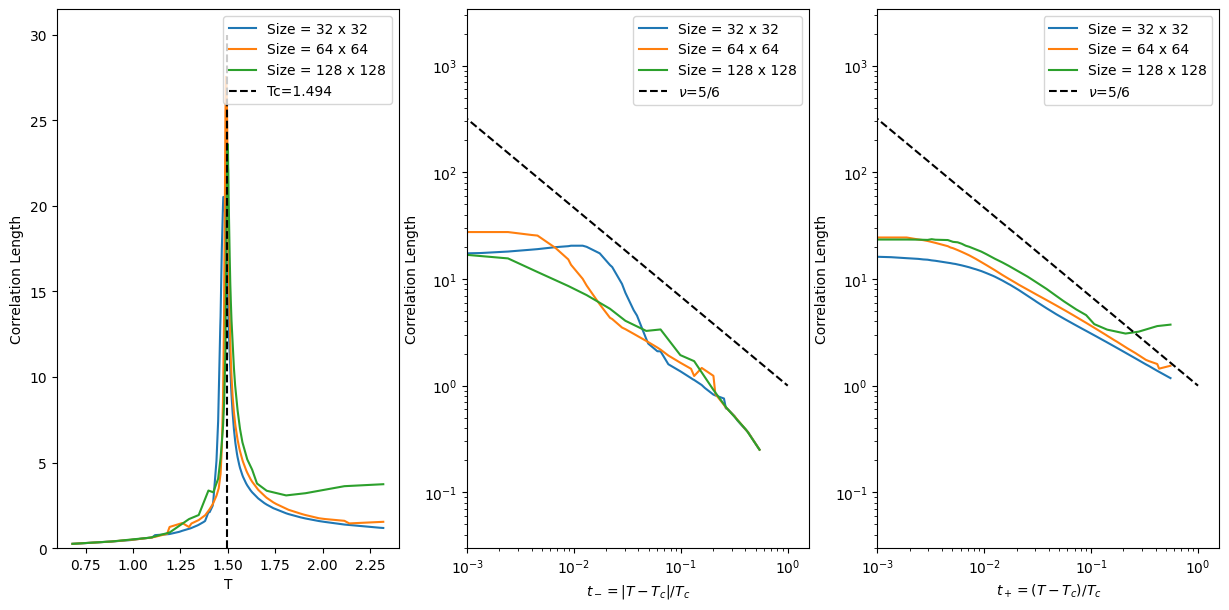

In [18]:
# x_min, x_max = (0, size/2/np.sqrt(2))
# y_min = 1.e-7

for data in result[:, Jv_list.index(Jv)]:
    data.correlation_length = get_correlation_length(data)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

# Tc = 1.492
# nu = 5/6

for data in result[size_list.index(32):size_list.index(128)+1, Jv_list.index(Jv)]:
    ax[0].plot(data.temperature, data.correlation_length, label=get_size(data))
    ax[1].plot((Tc-data.temperature)/Tc, data.correlation_length, label=get_size(data))
    ax[2].plot((data.temperature-Tc)/Tc, data.correlation_length, label=get_size(data))

ax[0].vlines(Tc, 0, 30, linestyle="--", color="k", label=f"Tc={Tc}")

def g(x):
    return x**(-nu)
x = np.linspace(0.0001, 1, 100)
ax[1].plot(x, g(x), "--", color="k", label = fr"$\nu$={nu}")
ax[2].plot(x, g(x), "--", color="k", label = fr"$\nu$={nu}")

ax[0].legend(loc="best")
ax[0].set_ylim([0, None])
ax[0].set_xlabel("T")
ax[0].set_ylabel("Correlation Length")

ax[1].legend(loc="best")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$t_-=|T-T_c|/T_c$")
ax[1].set_ylabel("Correlation Length")
ax[1].set_xlim([1.e-3, None])
ax[1].set_ylim([3.e-2, None])

ax[2].legend(loc="best")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlabel(r"$t_+=(T-T_c)/T_c$")
ax[2].set_ylabel("Correlation Length")
ax[2].set_xlim([1.e-3, None])
ax[2].set_ylim([3.e-2, None])

plt.legend()
plt.show()

In [15]:
# x_min, x_max = (1, size/max(16/np.sqrt(size),8))

# measure_eta = []

# for i, distance_list in enumerate(np.array(corr["irreducible_distance"])):
#     correlation = np.array(corr["correlation_function"])[i]
#     x, y = [], []
#     for j, distance in enumerate(distance_list):
#         if(x_min <= distance <= x_max):
#             x.append(np.log(distance))
#             y.append(np.log(correlation[j]))
    
#     x, y = np.array(x).reshape((-1, 1)), np.array(y)
    
#     # print(x, y)
#     model = LinearRegression().fit(x, y)
#     measure_eta.append(2-dimension-model.coef_)

# measure_eta = np.average(measure_eta)

# print(f"measure eta = {measure_eta}")
# print(f"real eta: {eta}")